# Import Library

In [1]:
import statsmodels.api as sm
import ccxt
import pandas as pd
import matplotlib.pyplot as plt
import requests
from statsmodels.tsa.stattools import coint

# Fetch Data

## BTC/USDT

In [2]:
binance = ccxt.binance()

In [3]:
since_timestamp = 1700510400000
until_timestamp = 1702481582000

limit = 1000
btc_usdt_ohlcv = []

while since_timestamp < until_timestamp:
    ohlcv_part = binance.fetch_ohlcv('BTC/USDT', '1h', since=since_timestamp, limit=limit)
    if not ohlcv_part:
        break
    btc_usdt_ohlcv.extend(ohlcv_part)
    since_timestamp = ohlcv_part[-1][0] + 1

In [4]:
btc_usdt_df = pd.DataFrame(btc_usdt_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
btc_usdt_df['timestamp'] = pd.to_datetime(btc_usdt_df['timestamp'], unit='ms') 
btc_usdt_df.set_index('timestamp', inplace=True)
btc_usdt_df

,open,high,low,close,volume
timestamp,,,,,
2023-11-20 20:00:00,37569.23,37597.62,37412.21,37548.69,1036.14601
2023-11-20 21:00:00,37548.68,37566.00,37271.10,37415.99,1077.34423
2023-11-20 22:00:00,37416.00,37570.72,37346.15,37425.78,948.85312
2023-11-20 23:00:00,37425.78,37605.76,37425.78,37448.78,901.20393
2023-11-21 00:00:00,37448.79,37516.48,37304.72,37394.17,807.25113
...,...,...,...,...,...
2023-12-18 10:00:00,41047.52,41067.01,40542.93,40823.50,3364.76098
2023-12-18 11:00:00,40823.50,41196.00,40783.29,41105.12,2267.27912
2023-12-18 12:00:00,41105.12,41120.01,40888.00,40905.28,1377.26734


## BTC/THB

In [8]:
btc_thb_url = "https://api.bitkub.com/tradingview/history?symbol={symbol}&resolution={timeframe}&from=1700510400&to=1702481582".format(symbol='BTC_THB', timeframe="60")
btc_thb_response = requests.get(btc_thb_url)
btc_thb_data = btc_thb_response.json()
del btc_thb_data["s"]
btc_thb_df = pd.DataFrame(btc_thb_data).rename(columns={
    "c": "close",
    "h": "high",
    "l": "low",
    "o": "open",
    "t": "timestamp",
    "v": "volume"
})
btc_thb_df['timestamp'] = pd.to_datetime(btc_thb_df['timestamp'], unit='s') 
btc_thb_df.set_index('timestamp', inplace=True)
btc_thb_df.head()

,close,high,low,open,volume
timestamp,,,,,
2023-11-20 20:00:00,1319072.89,1322000.00,1317736.7,1322000.00,0.279566
2023-11-20 21:00:00,1317502.58,1320599.46,1313401.0,1320599.46,3.038689
2023-11-20 22:00:00,1319810.46,1323193.84,1317500.0,1318131.45,1.801777
2023-11-20 23:00:00,1321884.88,1324900.00,1320000.0,1320150.00,3.046549
2023-11-21 00:00:00,1314982.53,1321884.20,1310000.0,1321884.20,6.396159


## USDT/THB

In [9]:
usdt_thb_url = "https://api.bitkub.com/tradingview/history?symbol={symbol}&resolution={timeframe}&from=1700488800&to=1702481582".format(symbol='USDT_THB', timeframe="1")
usdt_thb_response = requests.get(usdt_thb_url)
usdt_thb_data = usdt_thb_response.json()
del usdt_thb_data["s"]
usdt_thb_df = pd.DataFrame(usdt_thb_data).rename(columns={
    "c": "close_forex",
    "h": "high_forex",
    "l": "low_forex",
    "o": "open_forex",
    "t": "timestamp",
    "v": "volume_forex",
})
usdt_thb_df['timestamp'] = pd.to_datetime(usdt_thb_df['timestamp'], unit='s') 
usdt_thb_df.set_index('timestamp', inplace=True)
usdt_thb_df.tail()

,close_forex,high_forex,low_forex,open_forex,volume_forex
timestamp,,,,,
2023-12-13 15:29:00,35.73,35.73,35.72,35.73,2094.39
2023-12-13 15:30:00,35.72,35.73,35.72,35.73,550.15
2023-12-13 15:31:00,35.73,35.73,35.72,35.72,17123.49
2023-12-13 15:32:00,35.73,35.73,35.72,35.73,1109.56
2023-12-13 15:33:00,35.73,35.73,35.73,35.73,335.17


# Processing Data

In [10]:
merge_df = pd.merge(btc_thb_df, btc_usdt_df, on='timestamp', suffixes=('_thb', '_usdt'))
merge_df = pd.merge(merge_df, usdt_thb_df, on='timestamp', suffixes=('', '_forex'))

merge_df["convert_close_usdt"] = merge_df["close_usdt"] * merge_df["close_forex"]
merge_df["usdt_thb_diff"] = merge_df["convert_close_usdt"]-merge_df["close_thb"]

In [11]:
merge_df[['close_usdt','close_thb',"close_forex","convert_close_usdt","usdt_thb_diff"]].head()

,close_usdt,close_thb,close_forex,convert_close_usdt,usdt_thb_diff
timestamp,,,,,
2023-11-20 21:00:00,37415.99,1317502.58,35.21,1.317417e+06,-85.5721
2023-11-20 22:00:00,37425.78,1319810.46,35.25,1.319259e+06,-551.7150
2023-11-20 23:00:00,37448.78,1321884.88,35.28,1.321193e+06,-691.9216
2023-11-21 00:00:00,37394.17,1314982.53,35.28,1.319266e+06,4283.7876
2023-11-21 01:00:00,37600.61,1320960.46,35.13,1.320909e+06,-51.0307


In [12]:
# Perform cointegration test
result = coint(merge_df['close_thb'], merge_df['convert_close_usdt'])

# Extract test statistic and p-value
test_statistic, p_value, _ = result

# Print results
print('Cointegration Test:')
print('Test Statistic:', test_statistic)
print('p-value:', p_value)
print('Is Cointegrated:', p_value <= 0.05)

Cointegration Test:
Test Statistic: -20.226285125792053
p-value: 0.0
Is Cointegrated: True


# Plot Data

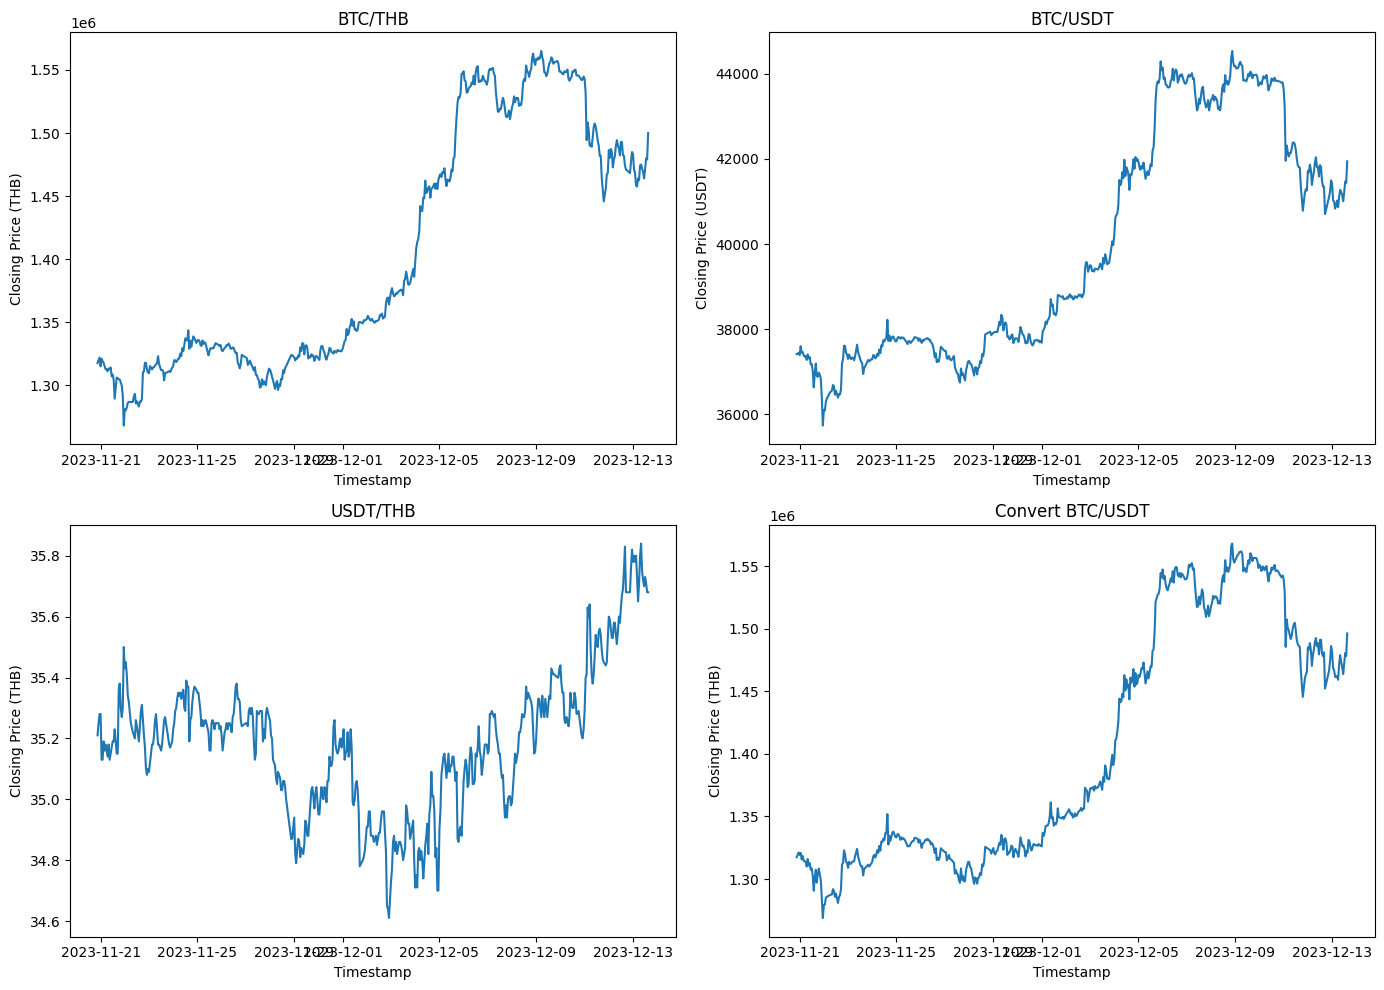

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

axes[0, 0].plot(merge_df["close_thb"])
axes[0, 0].set_title("BTC/THB")
axes[0, 0].set_xlabel("Timestamp")
axes[0, 0].set_ylabel("Closing Price (THB)")

axes[0, 1].plot(merge_df["close_usdt"])
axes[0, 1].set_title("BTC/USDT")
axes[0, 1].set_xlabel("Timestamp")
axes[0, 1].set_ylabel("Closing Price (USDT)")

axes[1,0].plot(merge_df["close_forex"])
axes[1,0].set_title("USDT/THB")
axes[1,0].set_xlabel("Timestamp")
axes[1,0].set_ylabel("Closing Price (THB)")

axes[1,1].plot(merge_df["convert_close_usdt"])
axes[1,1].set_title("Convert BTC/USDT")
axes[1,1].set_xlabel("Timestamp")
axes[1,1].set_ylabel("Closing Price (THB)")

plt.tight_layout()
plt.show()

In [14]:
close_thb = sm.add_constant(merge_df['close_thb'].to_list())
convert_close_usdt = merge_df['convert_close_usdt'].to_list()
results = sm.OLS(convert_close_usdt, close_thb).fit()
beta= results.params[1]

print("beta value: ",beta)

beta value:  0.9988373699079668


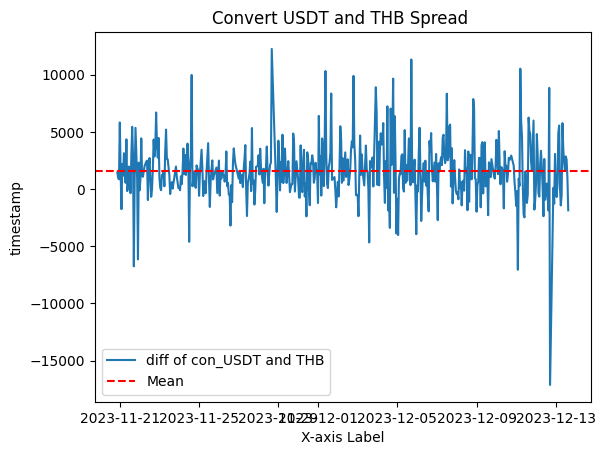

In [15]:
merge_df["spread"] = merge_df['convert_close_usdt'] - beta* merge_df['close_thb']
spread_mean = merge_df["spread"].mean()


plt.plot(merge_df["spread"], label='diff of con_USDT and THB')
plt.axhline(spread_mean, color='red', linestyle='--', label='Mean')

plt.xlabel('X-axis Label')
plt.ylabel('timestamp')
plt.title('Convert USDT and THB Spread ')

plt.legend()
plt.show()